# Кредитный скоринг юридических лиц

## Задача: Разработать модель кредитного скоринга юридического лица. Модель должна позволить определить, следует ли выдавать кредит юридическому лицу по заданным признакам

In [37]:
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
import seaborn as sns
import pandas as pd
import numpy as np
import pathlib
import os

sns.set()

### Этап 1: Импорт данных

In [2]:
print(*[f'Список файлов в репозитории {x.split("/")[-1]}: {sorted(os.listdir(x), key=lambda x: len(x))}' for x in ["./train", "./test"]], sep='\n')

Список файлов в репозитории train: ['train_1.csv', 'train_2.csv', 'train_3.csv', 'train_4.csv', 'train_5.csv', 'train_6.csv', 'train_7.csv', 'train_8.csv', 'train_9.csv', 'train_10.csv', '.ipynb_checkpoints']
Список файлов в репозитории test: ['test_1.csv', 'test_2.csv', 'test_3.csv', 'test_4.csv', 'test_5.csv', 'test_6.csv', 'test_7.csv', 'test_8.csv', 'test_9.csv', 'test_10.csv']


In [3]:
# Получим список путей к файлам в папке train
filenames_train = [x for x in sorted(os.listdir("./train"), key=lambda x: len(x)) if x.endswith(".csv")]

# Создадим список для записи считанных файлов train
data_files_train = []

# Считаем все файлы train и добавим их в список
for filename in filenames_train:
    # print(pathlib.Path.cwd().joinpath("./train", filename))
    data_files_train.append(pd.read_csv(pathlib.Path.cwd().joinpath("./train", filename)))

train_df = pd.concat(data_files_train, ignore_index=True)

print('Размерность полных тренировочных данных составляет: {} строка и {} столбец'.format(*train_df.shape))

Размерность полных тренировочных данных составляет: 38731 строка и 421 столбец


In [4]:
# Получим список путей к файлам в папке test
filenames_test = [x for x in sorted(os.listdir("./test"), key=lambda x: len(x)) if x.endswith(".csv")]

# Создадим список для записи считанных файлов test
data_files_test = []

# Считаем все файлы test и добавим их в список
for filename in filenames_test:
    # print(pathlib.Path.cwd().joinpath("./test", filename))
    data_files_test.append(pd.read_csv(pathlib.Path.cwd().joinpath("./test", filename)))

test_df = pd.concat(data_files_test, ignore_index=True)

print('Размерность полных тренировочных данных составляет: {} строка и {} столбец'.format(*test_df.shape))

Размерность полных тренировочных данных составляет: 19826 строка и 420 столбец


### Этап 2: Обзор набора данных

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38731 entries, 0 to 38730
Columns: 421 entries, target to feature_418
dtypes: float64(418), int64(2), object(1)
memory usage: 124.4+ MB


In [6]:
# train_df.describe()

In [7]:
print('Отсутствующие значения в наборе данных поездов:', sum(train_df.isnull().sum()))
print('Отсутствующие значения в наборе данных поездов:', sum(test_df.isnull().sum()))

Отсутствующие значения в наборе данных поездов: 0
Отсутствующие значения в наборе данных поездов: 0


### Этап 3: Обзор признаков

<Axes: xlabel='target', ylabel='Count'>

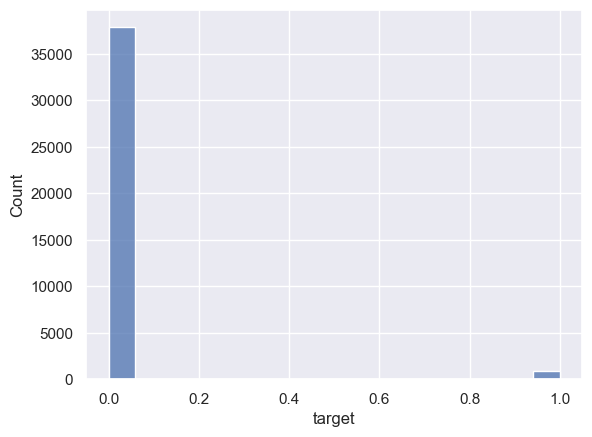

In [29]:
sns.histplot(train_df["target"])

#### Исследуем корреляцию признаков

In [33]:
# Получим матрицу корреляций
corr_matrix = train_df.drop(columns=["target", "smpl", "id"]).corr(method='spearman')

In [74]:
# Создать список пар признаков и их корреляций и отсортируем его по убыванию
# Получим все значения где показатель корреляции превышает порог:
threshold = 0.85

corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_value = abs(corr_matrix.iloc[i, j])
        if corr_value >= threshold:
            corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_value))
            
corr = np.array(sorted(corr, key=lambda x: x[2], reverse=True))

In [94]:
# Получим список частоты появления коррелирующих признаков
unique_features, counts = np.unique(np.append(corr[:, 0], corr[:, 1]), return_counts=True)

features_best_corr = pd.DataFrame({
    'Feature': unique_features,
    'Frequency': counts
})

features_best_corr.sort_values("Frequency", ascending=False).head(10)

,Feature,Frequency
9,feature_164,8
25,feature_341,5
34,feature_375,5
33,feature_372,5
5,feature_135,5
11,feature_17,5
13,feature_23,5
48,feature_84,4
38,feature_43,4
30,feature_366,4
